In [3]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import scipy.integrate as integrate
import scipy.stats as stats
import torch
import time
import pandas as pd

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

/nfs/scistore14/vogelgrp/awilson/miniconda3/envs/sbi_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [81]:
time = 1800
delta_t = 0.1
V_thr = 0


In [82]:
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

In [83]:
# function to run AdEx model - wrap in simulation wrapper
# priors for parameters - min vals, max vals, distribution (uniform)
# run sbi to find posterior
# draw samples from posterior and generate x (summary statistics)

In [84]:
# function to take in vector of params (size 9 or 10, depending on if including current) and run the AdEx model

def run_AdEx_model(params, time, delta_t):
    V_thr = 25
    params = np.asarray(params)
    cm = params[0]
    g_L = params[1]
    E_L = params[2]
    V_T = params[3]
    slope_f = params[4]
    a = params[5]
    tau_w = params[6]
    b = params[7]
    V_reset = params[8]
    # I = params[6]
    I = 35
    V = -60
    w = 0
    V_hist = []
    spike_times = []
    for idx,t in enumerate(np.arange(0,time,delta_t)):
        if V >= V_thr:
            V = V_reset
        V += delta_t*((-g_L*(V - E_L) + g_L * slope_f * np.exp((V - V_T)/slope_f) + I - w) / cm)
        w += delta_t*((a * (V - E_L) - w) / tau_w)
        # if V>=0 and V_hist[idx-1]<=0:
        #     spike_times.append(t)
        if V >= V_thr:
            V = V_thr
            w += b
        V_hist.append(V)
    return V_hist

In [85]:
# function to calculate the summary statistics of one simulation:
# These are spike number, latency to 1st spike, latency between spikes 1 and 2, latency between 2nd last and last
# spike, minimum voltage before spike 1, mean of resting and general voltage, standard deviation of the resting 
# and general voltage, skewness and kurtosis of the voltage

def calculate_summary_statistics(x,delta_t):
    V_thr = 25
    V_trace = np.array(x)
#     V_resting = V_trace[:int(t_on/delta_t)]
#     V_resting_mn = np.mean(V_resting)
#     V_resting_std = np.std(V_resting)
    spike_ind_int = np.where(V_trace >= V_thr)[0]
    if len(spike_ind_int) > 0:
        spike_ind = [spike_ind_int[0]]
        for i in range(len(spike_ind_int)-1):
            if spike_ind_int[i+1] - spike_ind_int[i] != 1:
                spike_ind.append(spike_ind_int[i+1])
        spike_times =  [i*delta_t for i in spike_ind]
        spike_num = len(spike_times)
    else:
        spike_times = []
        spike_num = 0
        latency_spike1 = 100000
        latency_spikes1_2 = 100000
        latency_spikes_last2 = 100000
    if spike_num == 1:
        latency_spike1 = spike_times[0]
        latency_spikes1_2 = 100000
        latency_spikes_last2 = 100000
    elif spike_num > 1:
        latency_spike1 = spike_times[0]
        latency_spikes1_2 = spike_times[1] - spike_times[0]
        latency_spikes_last2 = spike_times[-1] - spike_times[-2]
    mean_V = np.mean(V_trace)
    std_V = np.std(V_trace)
    skew_V = stats.skew(V_trace)
    kurtosis_V = stats.kurtosis(V_trace)
#     V_pre_spike1_sampled = V_pre_spike_1[0::(1/delta_t)]
    min_V = np.min(V_trace)
    sum_stats = np.array((spike_num, latency_spike1, latency_spikes1_2, latency_spikes_last2, \
                           min_V, mean_V, std_V, skew_V, kurtosis_V))
#     sum_stats = np.array((spike_num, latency_spike1, latency_spikes1_2, latency_spikes_last2, \
#                                min_V_pre_spike1, V_resting_mn, V_resting_std, mean_V, std_V, skew_V, kurtosis_V))
#     sum_stats = np.array((spike_num, mean_V, std_V, skew_V, kurtosis_V))
    return sum_stats
    

In [86]:
# calculate the costs of all the experimental statistics

def calc_costs(sim_stats, exp_stats):
    cost_stat1 =  (exp_stats[0] - sim_stats[0])**2 / abs(exp_stats[0])
    cost_stat2 = (exp_stats[1] - sim_stats[1])**2 / abs(exp_stats[1])
    cost_stat3 = (exp_stats[2] - sim_stats[2])**2 / abs(exp_stats[2])
    cost_stat4 = (exp_stats[3] - sim_stats[3])**2 / abs(exp_stats[3])
    cost_stat5 = (exp_stats[4] - sim_stats[4])**2 / abs(exp_stats[4])
    cost_stat6 = (exp_stats[5] - sim_stats[5])**2 / abs(exp_stats[5])
    cost_stat7 = (exp_stats[6] - sim_stats[6])**2 / abs(exp_stats[6])
    cost_stat8 = (exp_stats[7] - sim_stats[7])**2 / abs(exp_stats[7])
    cost_stat9 = (exp_stats[8] - sim_stats[8])**2 / abs(exp_stats[8])
    # cost_stat10 = (exp_stats[9] - sim_stats[9])**2 / abs(exp_stats[9])
    # cost_stat11 = (exp_stats[10] - sim_stats[10])**2 / abs(exp_stats[10])
    total_cost = cost_stat1 + cost_stat2 + cost_stat3 + cost_stat4 + cost_stat5 + cost_stat6 + cost_stat7 \
    + cost_stat8 + cost_stat9 #+ cost_stat10 + cost_stat11
#     total_cost = cost_stat1 + cost_stat2 + cost_stat3 + cost_stat4 + cost_stat5 
    return total_cost

In [87]:
# simulation wrapper to take in the parameters, run an AdEx simulation and calculate the summary statistics

def simulation_wrapper(params):
    obs = run_AdEx_model(params, time, delta_t)
    summstats = torch.as_tensor(calculate_summary_statistics(obs, delta_t))
    return summstats

In [88]:
# obs_stats = [9,50,45,80,-55]

# generate the experimental statistics (usually would be calculated directly from experimental trace)

# with current
# exp_params = np.array([59,2.9,-62,-42,3,1.8,16,61,-54,184])
# w/o current
# exp_params = np.array([59,2.9,-62,-42,3,1.8,16,61,-54])
# exp_trace = run_AdEx_model(exp_params,time,delta_t,V_thr)
# exp_stats = calculate_summary_statistics(exp_trace,delta_t,V_thr,t_on)

# plt.plot(np.arange(0,time,delta_t), exp_trace)
# plt.xlabel("time (ms)")
# plt.ylabel("voltage (mV)")
# plt.savefig('Figures/AdEx_cNA.png')

# generate experimental statistics from data
time = 1800 
delta_t = 0.1
t_on = 0

filename = 'data/aIN_1311_f109.txt'
columns = ['Time (s)', 'Voltage (mV)']
df = pd.read_csv(filename,header=None,names=columns,skiprows=0,delim_whitespace=True)
exp_trace = df['Voltage (mV)'].values.tolist()
# exp_trace = [v*100 for v in exp_trace_int]
exp_stats = calculate_summary_statistics(exp_trace,delta_t)
print(exp_stats)


[ 26.           2.          57.          54.6        -46.191406
 -37.35200742   9.80788662   4.2013764   21.19512737]


In [89]:
# Generate prior distribution on parameters
# Parameters to find: cm, g_L, E_L, VT, slope_f, a, tau_w, b, V_r, (I)

# including current as parameter

prior_min = [0, 0, -70, -50, 5, 0, 1, 0, -80]
prior_max = [120, 6, -20, -10, 20, 20, 100, 200, -20]
prior =utils.torchutils.BoxUniform(
        low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

# not including current as parameter
# prior_min = [0, 0, -90, -60, 0, 0, 1, 0, -80]
# prior_max = [120, 6, -30, -20, 10, 10, 50, 200, -20]
# prior =utils.torchutils.BoxUniform(
#         low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

# posterior = infer(simulation_wrapper, prior, method='SNPE', num_simulations=100, num_workers=4)

In [90]:
simulator, prior = prepare_for_sbi(simulation_wrapper,prior)
inference = SNPE(prior=prior)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:  60%|██████    | 603/1000 [00:30<00:19, 20.78it/s]/tmp/ipykernel_528290/805086194.py:25: RuntimeWarning: overflow encountered in scalar multiply
  w += delta_t*((a * (V - E_L) - w) / tau_w)
/tmp/ipykernel_528290/805086194.py:25: RuntimeWarning: invalid value encountered in scalar add
  w += delta_t*((a * (V - E_L) - w) / tau_w)
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:49<00:00, 20.10it/s]


 Neural network successfully converged after 83 epochs.

Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 89.54it/s]


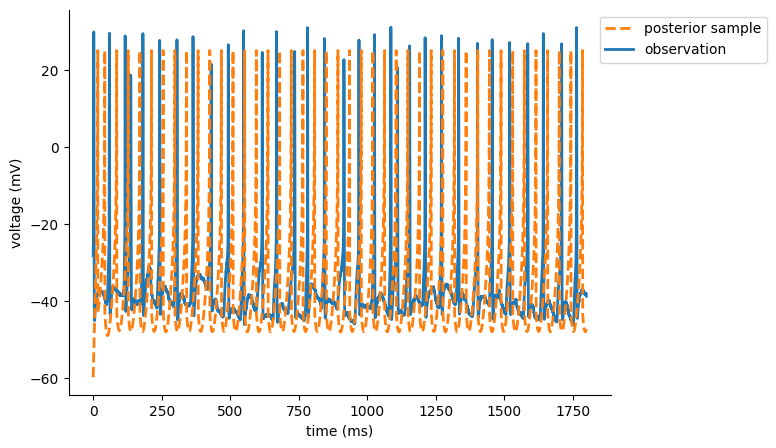

In [91]:
# single round SBI
theta, x = simulate_for_sbi(simulator, prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta,x,proposal=prior).train()
posterior = inference.build_posterior(density_estimator)
posterior_sample = posterior.sample((1,), x=exp_stats).numpy()

fig = plt.figure(figsize=(7, 5))

# plot observation
# t = observation_trace["time"]
y_obs = exp_trace
plt.plot(np.arange(0,time,delta_t), y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_AdEx_model(posterior_sample[0], time, delta_t)
# sum_stats = calculate_summary_statistics(x,delta_t,V_thr,t_on)
# cost = calc_costs(sum_stats,exp_stats)
plt.plot(np.arange(0,time,delta_t), x, "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")
# plt.savefig('Figures/SBI_eg_aIN_7params.png')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

Drawing 1 posterior samples: 5383it [00:00, 8606.17it/s]          


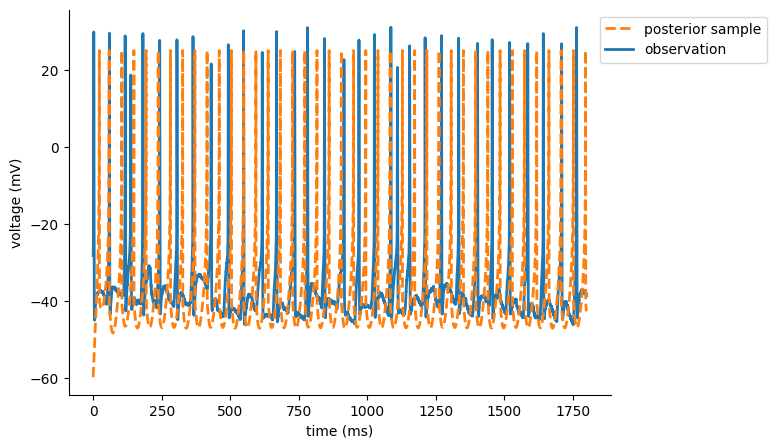

In [73]:
posterior_sample = posterior.sample((1,), x=exp_stats).numpy()

fig = plt.figure(figsize=(7, 5))

# plot observation
# t = observation_trace["time"]
y_obs = exp_trace
plt.plot(np.arange(0,time,delta_t), y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_AdEx_model(posterior_sample[0], time, delta_t)
# sum_stats = calculate_summary_statistics(x,delta_t,V_thr,t_on)
# cost = calc_costs(sum_stats,exp_stats)
plt.plot(np.arange(0,time,delta_t), x, "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")
plt.savefig('Figures/SBI_eg_aIN_7params.png')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

Drawing 10000 posterior samples: 10793it [00:00, 15945.78it/s]                          


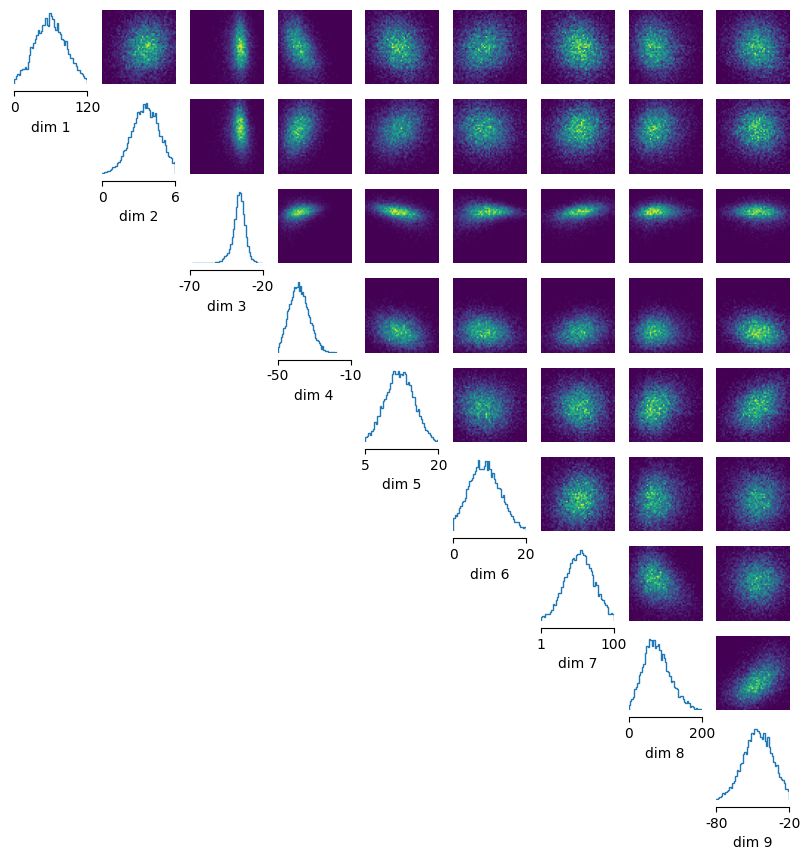

In [92]:
samples = posterior.sample((10000,), x=exp_stats)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0, 120], [0, 6], [-70, -20], [-50, -10], [5, 20], [0, 20], [1, 100], [0, 200], [-80, -20]],
    ticks=[[0, 120], [0, 6], [-70, -20], [-50, -10], [5, 20], [0, 20], [1, 100], [0, 200], [-80, -20]],
    # limits=[[-50, -10], [5, 20], [0, 20], [1, 100], [0, 150], [-80, -20], [0,500]],
    # ticks=[[-50, -10], [5, 20], [0, 20], [1, 100], [0, 150], [-80, -20], [0,500]],
    figsize=(10, 10),
#     points=exp_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
);

plt.savefig('Figures/pairplot_ain_35pA.png')



In [93]:
mode = []
for i in range(9):
    mode.append(samples[:,i].mean())
print(mode)

[tensor(58.8824), tensor(3.5285), tensor(-36.5584), tensor(-38.2528), tensor(12.0195), tensor(8.6418), tensor(53.1160), tensor(77.3416), tensor(-46.1439)]


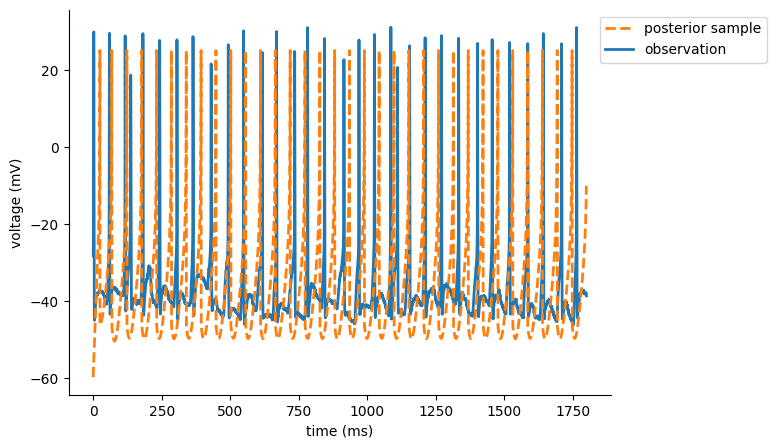

In [94]:

params = [58.8824, 3.5285, -36.5584, -38.2528, 12.0195, 8.6418, 53.1160, 77.3416, -46.1439]

fig = plt.figure(figsize=(7, 5))

# plot observation
# t = observation_trace["time"]
y_obs = exp_trace[:18000]
plt.plot(np.arange(0,time,delta_t)[:18000], y_obs, lw=2, label="observation")

# simulate and plot samples
# sum_stats = calculate_summary_statistics(x,delta_t,V_thr,t_on)
# cost = calc_costs(sum_stats,exp_stats)
x = run_AdEx_model(params, 5000.1, 0.1)[:18000]
plt.plot(np.arange(0,time,delta_t)[:18000], x, "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")
plt.savefig('Figures/SBI_mn_mean_1000sims.png')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

2nd round of sbi to try to match F-I curve

In [ ]:
time = 1300
delta_t = 0.1
V_thr = 0

In [96]:
# function to take in vector of params (size 9) and run the AdEx model at different currents

def run_AdEx_model_fr(params, time, delta_t):
    I = 0
    V_thr = 25
    params = np.asarray(params)
    cm = params[0]
    g_L = params[1]
    E_L = params[2]
    V_T = params[3]
    slope_f = params[4]
    a = params[5]
    tau_w = params[6]
    b = params[7]
    V_reset = params[8]
    V = -60
    w = 0
    V_hist = []
    spike_times = []
    for idx,t in enumerate(np.arange(0,time,delta_t)):
        if t % 100 == 0:
            I += 10
        if V >= V_thr:
            V = V_reset
        V += delta_t*((-g_L*(V - E_L) + g_L * slope_f * np.exp((V - V_T)/slope_f) + I - w) / cm)
        w += delta_t*((a * (V - E_L) - w) / tau_w)
        # if V>=0 and V_hist[idx-1]<=0:
        #     spike_times.append(t)
        if V >= V_thr:
            V = V_thr
            w += b
        V_hist.append(V)
    return V_hist

In [97]:
def calculate_frs(x,delta_t):
    V_thr = 25
    V_trace = np.array(x)
    split_vs = []
    frs = []
    current_steps = [100*i for i in range(0,13,1)]
    for idx,val in enumerate(current_steps):
        if idx < len(current_steps)-1:
            split_vs.append(V_trace[val:current_steps[idx+1]])
        else:
            split_vs.append(V_trace[val:])
    for vs in split_vs:
        fr = len(np.where(vs >= V_thr)[0])
        frs.append(fr) 
    return frs

In [98]:
# calculate the costs of all the experimental statistics

def calc_costs_fr(sim_stats, exp_stats):
    cost = 0 
    for i in len(exp_stats):
        cost +=  (exp_stats[i] - sim_stats[i])**2
    return cost

In [99]:
# simulation wrapper to take in the parameters, run an AdEx simulation and calculate the summary statistics

def simulation_wrapper(params):
    obs = run_AdEx_model_fr(params, time, delta_t)
    summstats = torch.as_tensor(calculate_frs(obs, delta_t))
    return summstats

In [100]:
proposal = posterior.set_default_x(exp_stats)
simulator, prior = prepare_for_sbi(simulation_wrapper,proposal)
inference = SNPE(prior=prior)

Drawing 2 posterior samples: 8396it [00:00, 15504.99it/s]         
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 86.28it/s]
Drawing 1 posterior samples: 8384it [00:00, 16714.25it/s]         
/nfs/scistore14/vogelgrp/awilson/miniconda3/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/user_input_checks_utils.py:392: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
Drawing 1000 posterior samples: 1089it [00:00, 12800.88it/s]            
/nfs/scistore14/vogelgrp/awilson/miniconda3/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
Drawing 1000 posterior samples: 1088it [00:00, 12568.14it/s]            
/nfs/scistore14/vogelgrp/awilson/miniconda3/envs/sbi_env/lib/python3.11/site-packages/sbi/utils/user_input_checks_utils.py:80: UserWarn

In [101]:
theta, x = simulate_for_sbi(simulator, prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta,x,proposal=prior).train()
posterior = inference.build_posterior(density_estimator)

Drawing 1000 posterior samples: 1084it [00:00, 11473.35it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:51<00:00, 19.31it/s]


 Neural network successfully converged after 76 epochs.

Drawing 2 posterior samples: 100%|██████████| 2/2 [00:00<00:00, 168.20it/s]


In [102]:
exp_frs = [0, 0, 0, 20, 36, 55, 65, 72, 78, 88, 92, 100, 108]

Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 72.58it/s]


NameError: name 'frs' is not defined

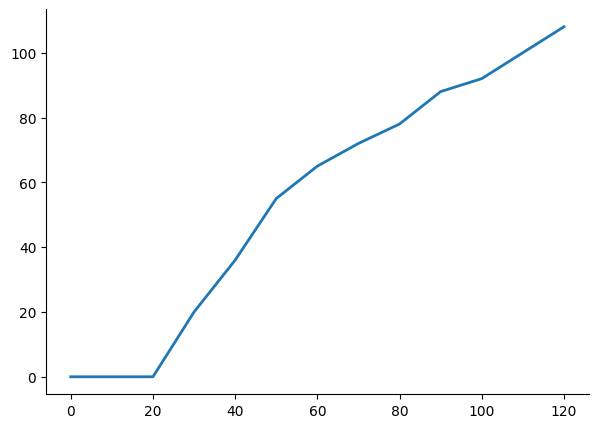

In [106]:
posterior_sample = posterior.sample((1,), x=exp_frs).numpy()
Is = [0,10,20,30,40,50,60,70,80,90,100,110,120]
fig = plt.figure(figsize=(7, 5))

# plot F-I curves
plt.plot(Is, exp_frs, lw=2, label="observation")
plt.plot(Is, frs, "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")
# plt.savefig('Figures/SBI_eg_aIN_7params.png')

y_obs = exp_trace
plt.plot(np.arange(0,time,delta_t), y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_AdEx_model(posterior_sample[0], time, delta_t)
# sum_stats = calculate_summary_statistics(x,delta_t,V_thr,t_on)
# cost = calc_costs(sum_stats,exp_stats)
plt.plot(np.arange(0,time,delta_t), x, "--", lw=2, label="posterior sample")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

In [525]:
simulator, prior = prepare_for_sbi(simulation_wrapper,prior)
inference = SNPE(prior=prior)

In [41]:
# multi-round

num_rounds = 2
posteriors = []
proposal = prior

x_o = exp_stats

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500, num_workers=4)
    density_estimator = inference.append_simulations(theta,x,proposal=proposal).train(force_first_round_loss=True)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)
    
posterior_sample = posterior.sample((1,), x=exp_stats).numpy()

fig = plt.figure(figsize=(7, 5))

# plot observation
# t = observation_trace["time"]
y_obs = exp_trace
plt.plot(np.arange(0,time,delta_t), y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_AdEx_model(posterior_sample[0], time, delta_t, V_thr)
sum_stats = calculate_summary_statistics(x,delta_t,V_thr,t_on)
print(sum_stats)
cost = calc_costs(sum_stats,exp_stats)
print(cost)
plt.plot(np.arange(0,time,delta_t), x, "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")
plt.savefig('Figures/SBI_eg_cNA_2rounds1000sims.png')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

ValueError: min() arg is an empty sequence

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    1 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


[  8.         137.63        52.21        48.31       -69.98642973
 -35.470639    12.47063983 -35.11902062  17.10919657  -0.17402137
  -0.97392626]
227.6771342076438


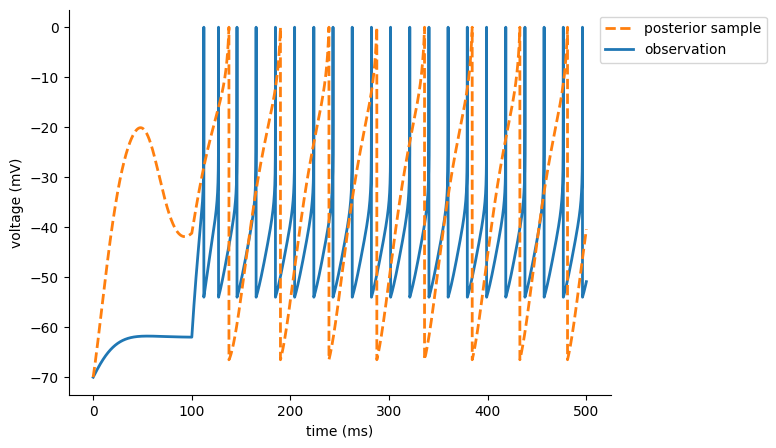

/home/awilson/anaconda3/envs/sbi_env/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/awilson/anaconda3/envs/sbi_env/lib/python3.7/site-packages/scipy/stats/stats.py:955: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/awilson/anaconda3/envs/sbi_env/lib/python3.7/site-packages/scipy/stats/stats.py:959: RuntimeWarning: overflow encountered in square
  s = s**2
/home/awilson/anaconda3/envs/sbi_env/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/awilson/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/home/awilson/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in subtract
/home/awilson/anaconda3/envs/sbi

In [532]:
posterior_sample = posterior.sample((1,), x=exp_stats).numpy()

fig = plt.figure(figsize=(7, 5))

# plot observation
# t = observation_trace["time"]
y_obs = exp_trace
plt.plot(np.arange(0,time,delta_t), y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_AdEx_model(posterior_sample[0], time, delta_t, V_thr)
sum_stats = calculate_summary_statistics(x,delta_t,V_thr,t_on)
print(sum_stats)
cost = calc_costs(sum_stats,exp_stats)
print(cost)
plt.plot(np.arange(0,time,delta_t), x, "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")
plt.savefig('Figures/SBI_eg_cNA_2rounds1000sims.png')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")


In [203]:
posterior_sample

array([[ 21.075188 ,   3.0558274, -63.981995 , -36.39224  ,   3.8985312,
          2.4173067,  38.620926 , 141.55396  , -52.029198 , 301.9906   ]],
      dtype=float32)

/home/awilson/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/home/awilson/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
